# CNNs

# Convolutional Neural Network

# ... giving your model the power of `sight`

---

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit

import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

matplotlib.style.use('ggplot')

In [2]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

In [3]:
# Set up our tensorflow session.
# sess = tf.InteractiveSession()
# tf.global_variables_initializer().run()
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


# Convolutional Neural Networks

Most (all?) machine learning models we have studied so far have been intended to solve very *general* problems.  Convolutional Neural Networks (ConvNets/CNN) are different, they are designed to address a very specific learning task, **image classification**.

Generalizations of ConvNets have been invented to handle other tasks:

  - Audio recognition.
  - Sentiment Analysis in Text.
  - Text Generation (Say, Captioning).  

Many of the main ideas stay mostly the same for these problems, but are adapted to the structure of other types of data.

## Image Classification

**Image Classification** is the task of learning how to label an image.  We are given a set of images to train our model, each with a label identifying its contents:

  - Dog vs. Cat.
  - Name of a digit (0, 1, ..., 9).
  - Name of a flower.
  
The goal of our algorithm is then to learn the *label* of the image from its *contents* (that is, learn the label from the image itself).

### Tensors

We are going to represent images as **tensors**.  Tensors (in machine learning, not mathematics, [tensor](https://en.wikipedia.org/wiki/Tensor) means [something different](http://stats.stackexchange.com/a/198395/74500) in mathematics) are simply multi-dimensional arrays.

  - A one dimensional tensor is a vector.
  - A two dimensional tensor is a matrix.
  - A tensor of larger dimensionality is called a 3-tensor, 4-tensor, etc.
  
So to get an element from a 3-tensor, you need to give it three indices:

```python
three_tensor[i, j, k]
```

And you can slice 3-tensors to get matrices:

```python
# Slicing a 3-tensor by fixing one index gives a 2-tensor, aka a matrix.
three_tensor[i, :, :]
three_tensor[:, j, :]
three_tensor[:, :, k]
```

or vectors:

```python
# Slicing a 3-tensor by fixing one indices gives a 1-tensor, aka a vector.
three_tensor[i, j, :]
three_tensor[:, j, k]
three_tensor[i, :, k]
```

### Dataset: `mnist`

The MNIST dataset contains 70,000 grayscale images in 10 digits. The images show individual handwritten digits at low resolution (28 by 28 pixels, size-normalized and centered); [more here](http://yann.lecun.com/exdb/mnist/index.html). 

[top-1 vs top-5 error rate](https://stats.stackexchange.com/questions/156471/imagenet-what-is-top-1-and-top-5-error-rate)

In [86]:
## it could take sometime ~mins download the dataset if you haven't done so already
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

In [87]:
train_images.shape

(60000, 28, 28)

In [88]:
train_images.shape[0]

60000

In [89]:
## class labels
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

If we inspect the first object, we could see a picture of `5`. 

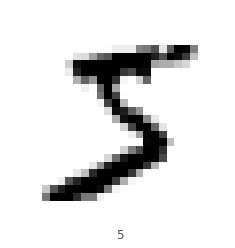

In [90]:
i = 0
plt.figure()
plt.imshow(train_images[i], cmap=plt.cm.binary)
# plt.colorbar()
plt.xticks([]); plt.yticks([]); plt.grid(False)
plt.xlabel(train_labels[i]);

### Grayscale Images

A single greyscale image can be represented as a matrix.  The entries in the matrix represent **pixel intensities**, ranging from 0 to 255.  A value of 0 represents a white pixel, and a value of nonzero represents a black pixel.

In [91]:
train_images[i][:13, :13] ## the left up corner of the picture 

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190]],
      dtype=uint8)

Before feeding the image to the neural network model, we need to scale the intensity onto between 0 and 1. 

In [92]:
train_images = train_images / 255.0; test_images = test_images / 255.0

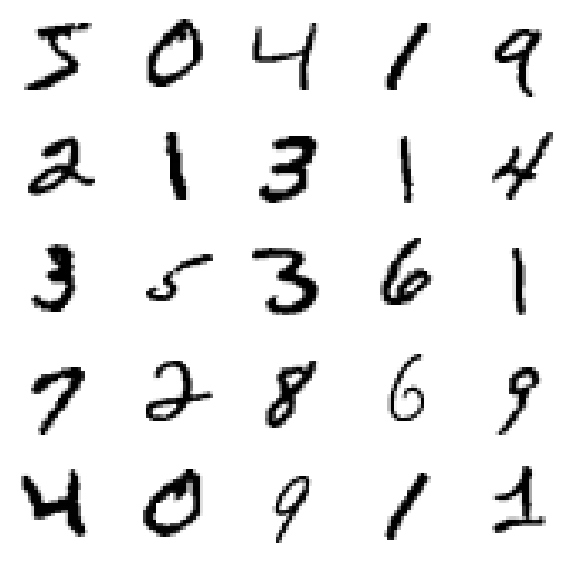

In [93]:
# show the first 25 images
# remove_grid_lines(axs)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

Each image of handwritten digit is represented as a 2-tensor (matrix), and is 28 pixels wide and 28 pixels high.

We will often refer to pixel intensities in an image as **activations** in the following way.  Pixels that are "on", or black, are said to be **activated**.  In this way, each digit should be characterized by a characteristic pattern of activations.

In [94]:
digit_training = train_images.reshape(-1, 28, 28)
first_digit_image = train_images[0]
print("Shape of digit image: {}".format(first_digit_image.shape))

Shape of digit image: (28, 28)


In [97]:
train_images.shape

(60000, 28, 28)

The entire training data is a stack of 28 by 28 images, which is a 3-tensor.

In [95]:
print("Shape of training data: {}".format(digit_training.shape))

Shape of training data: (60000, 28, 28)


Since `plt.imshow` obscures what is going on a bit, below we can build our own simple plotter by drawing a `.` when the pixel intensity is less than 0.5, and drawing a `#` when it is bigger than 0.5.

In [14]:
def ascii_grayscale_image(img):
    image_shape = img.shape
    ascii = np.array(['#', '.'])[(img >= 0.5).astype(int).flatten()].reshape(image_shape)
    return '\n'.join([''.join(row) for row in ascii])

Now it's easy to see how the matrix represents an image of a digit.

In [15]:
print(ascii_grayscale_image(first_digit_image))

############################
############################
############################
############################
############################
#################..#...#####
###########............#####
########..........##########
########..........##########
#########.#...###.##########
###########..###############
###########...##############
############..##############
#############...############
##############...###########
###############....#########
#################...########
#################...########
###############.....########
#############.......########
############......##########
##########......############
#######.......##############
#####........###############
####.......#################
############################
############################
############################


### Color Images

Color images are more complex than greyscale.

Instead of a single image being represented as a matrix (greyscale), color images are represented as **three matrices**.  Each of these three matrices is called a **channel**, and holds information on one dimension of the color space.

The standard three channels are RGB, or a **red** channel, a **green** channel, and a **blue** channel.

By stacking these together into a 3-tensor, we can represent a color image as a single object.

--> Picture of a three tensor with channels labeled.

We will use the [Oxford Flowers Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/index.html) as our example of color images.

To download the data set, use the following shell commands:

```bash
curl http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
tar -zxvf 17flowers.tgz
```
- x for extract
- v for verbose
- z for gunzip
- f for file, should come at last just before file name.

You will now have a directory containing many color images of flowers.

Set the following variable to the path of the directory you un-tarred your flower images into.

In [16]:
flowers_path = "data"

Loading this data into Tensorflow 1.x is somewhat awkward, but now with 2.0 it is more pythonic.

For a single file, you can simply use function `tf.io.read_file` to read in the raw data, followed by `tf.image.decode_image` to convert it into tensor. 

In [17]:
file_path = flowers_path + "/image_0001.jpg"
raw_image = tf.io.read_file(file_path)
image = tf.image.decode_jpeg(raw_image, channels=3)

In [18]:
image.shape

TensorShape([500, 689, 3])

The $3$ in the final dimension is the number of color channels.  We see that:

  - This color image is indeed a three tensor.
  - The final dimension is $3$, showing that we do indeed have three color channels.

The proof of the pudding is in the eating of said pudding, so here's the actual image in all it's beauty:

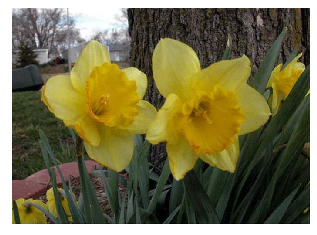

In [19]:
plt.imshow(image)
plt.grid(False)
plt.xticks([]); plt.yticks([]);

We can also display each of the color channels separately.

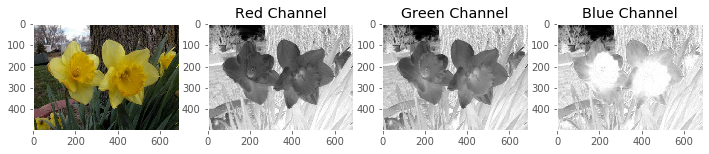

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))

axs[0].imshow(image)
axs[0].grid(False)
for i in range(1, 4):
    axs[i].imshow(image[:, :, i-1], cmap=plt.cm.gray_r)
    axs[i].set_title("{} Channel".format(["Red", "Green", "Blue"][i-1]))

remove_grid_lines(axs)

To build a dataset of images we create a `tf.data.Dataset` using `from_tensor_slices` method. [More details](https://www.tensorflow.org/alpha/tutorials/load_data/images#load_and_format_the_images)

In [21]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

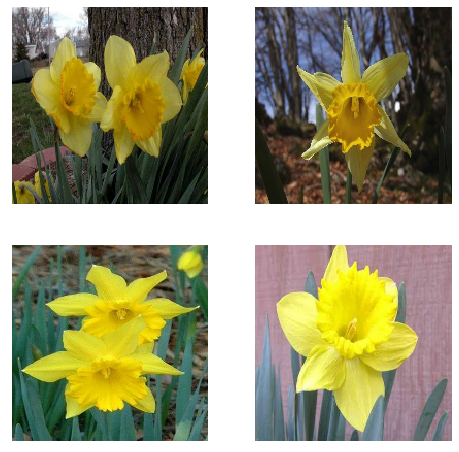

In [22]:
# The number of flower images:
n_flower_images = 1360
# The format specification here left pads zeros on the number: 0004.
flower_filenames = [flowers_path + '/image_{:04d}.jpg'.format(i)
                    for i in range(1, n_flower_images + 1)]
## slicing the array of strings, resulting in a set of scalar binary-strings
path_ds = tf.data.Dataset.from_tensor_slices(flower_filenames)

## create a new dataset that loads and formats images on the fly
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

plt.figure(figsize = (8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

In tf 1.x, it can stack images together and the entire dataset would be a 4-tensor. However, it is slightly different in 2.0. 

In [23]:
image_ds

<ParallelMapDataset shapes: (192, 192, 3), types: tf.float32>

## Deficiencies of Fully Connected Networks

In an earlier assignment, we used a fully connected neural network to classify digits in the MNIST digit dataset.

Let's review that model, and then discuss some deficiencies of the approach.

### Fully Connected Network Review

In a fully connected network we view each pixel of the input image as a feature.  So instead of viewing an input image as a 2-tensor, we instead **flatten** it into a 1-tensor.

![Flattening a Matrix](./img/image-flatten.png)

To classify an image, we create a unique linear combination of the pixel intensity values for each possible class.  Each pixel participates exactly once in each class's linear combination:

$$ L_j = \underbrace{b_j + W_{1j} x_{1j} + W_{2j} x_{2j} + \cdots + W_{pj} x_{pj}}_{\text{One Summand for Each Pixel}} $$

To assign probabilities to each of the classes, we pass our linear combinations through the **softmax** function.

$$ P_j = {\rm softmax}(b_j + W_{1j} x_{1j} + W_{2j} x_{2j} + \cdots + W_{pj} x_{pj})_j $$

It is common to visualize this as a network diagram with:
    - One input layer, representing the pixel intensities in an image.
    - One pre-output layer, representing the linear combination of pixel intensities.
    - One output layer, containing probabilities.

![Fully Connected Network with No Hidden Lectures](./img/nn-fc-small.png)

In [24]:
model = keras.Sequential()
## unstacking rows of pixels in the image and lining them up
model.add(keras.layers.Flatten(input_shape=(28, 28)))
## The second (and last) layer is a 10-node softmax layer that 
##    returns an array of 10 probability scores that sum to 1
model.add(keras.layers.Dense(10, activation='softmax'))

What did we build? What does each layer do? How many parameters are we training at each layer?

In [25]:
# 784 pixel values into each neuron (10), plus an additional 10 bias values (one for each neuron)
(784 * 10) + 10

7850

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Alternatively, we can simply build the model layer by layer in one line (well sorta)
```
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='softmax')
])
```

---

Then we need to compile the model [tf2.0 tutorial](https://www.tensorflow.org/alpha/tutorials/keras/basic_classification])

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit(train_images, train_labels, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 51us/sample - loss: 0.4678 - accuracy: 0.8777
Epoch 2/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.3042 - accuracy: 0.9154
Epoch 3/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.2836 - accuracy: 0.9209
Epoch 4/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2735 - accuracy: 0.9237
Epoch 5/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2666 - accuracy: 0.9258
Epoch 6/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2621 - accuracy: 0.9269
Epoch 7/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2584 - accuracy: 0.9286
Epoch 8/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.2550 - accuracy: 0.9294
Epoch 9/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2531 - accuracy: 0.9298
Epoch 10/10
60

In [29]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy {:5.2f}%'.format(100*test_acc))

10000/10000 [==============================] - 0s 34us/sample - loss: 0.2613 - accuracy: 0.9284

Test accuracy 92.84%


The fully connected network classifies $92\%$+ of the digits correctly.  We will be able to improve on this with a convolutional network. 

In [30]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


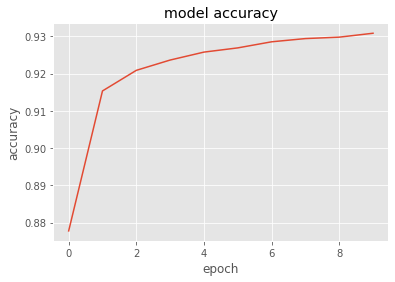

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch');

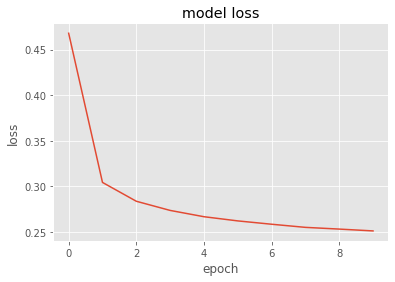

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch');
# plt.legend(['train', 'test'], loc='upper left')

### Flattening

The most glaring deficiency of the fully connected network is its *flattening of the images*.

Images have structure that is destroyed when flattening them.  Pixels that **were** close together become far apart after flattening.

![Image Flattening With Shaded Pixels](./img/img-flatten-non-local.png)

We should expect the neighbouring pixels in an image to combine in ways that convey information.  Flattening the image makes it extremely difficult for the network to detect information conveyed by close together pixels.

We can see this by plotting the fit weights in the fully connected network.

In [33]:
def plot_digit_weights(ax, digit):
    """Plot the weights from our fit fully connected network as an image."""
    digit_weigths = np.reshape(model.weights[0][:,digit], (28,28))
    ax.imshow(digit_weigths, cmap=plt.cm.winter, interpolation="nearest")    

In [34]:
# there are 784 weights for each neuron
model.weights[0].shape

TensorShape([784, 10])

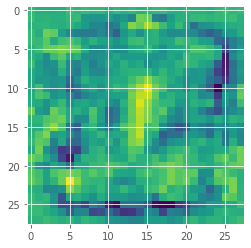

In [35]:
# this is what the number 1 "looks like"
plt.imshow(model.weights[0][:,1].numpy().reshape(28,28));

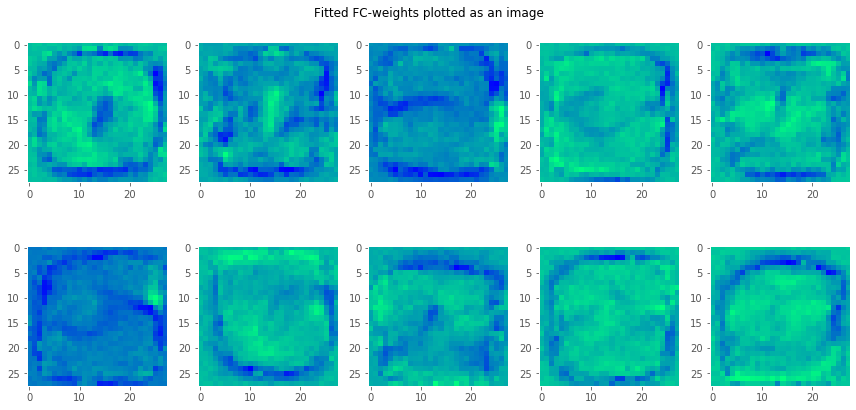

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for digit, ax in enumerate(axs.flatten()):
    plot_digit_weights(ax, digit)

remove_grid_lines(axs)
fig.suptitle("Fitted FC-weights plotted as an image")
plt.tight_layout()

The weights for simple digits (zero, one) show considerable structure.

The weights for more complex digits (four, five, nine) are a bit of a mess. The network clearly had some issues structuring the weights into comprehensible signal.

### Absolute Positioning

Looking at the weights above again, we can see that the fully connected network is only sensitive to the shape of the digit if they are **in the same general position of the image every time**.

If, for example, we had an image of 6, but positioned in the upper right hand corner of our image, we would totally fail to detect it.  Even retraining the network on a new batch of images that have been shifted or rotated around would not help, as we are assigning weights to each (digit, pixel) combination.

A ConvNet will learn features that can be applied anywhere in the image, which will fix this issue.

### Number of Parameters

Recall, our fully connected network fits a huge number of parameters.  There are:
  - `n_digit` bias parameters.
  - `n_digit * n_pixels` weight parameters.
  
Overall the network we fit has:

$$ 10 + (10 \times 28 \times 28) = 7850 $$

parameters.  We will be able to reduce this number with a convolutional approach.

## Image Transformations: Convolutions and Pooling

The major conceptual building block of ConvNets are **convolutions**.  These are linear operations that transform an image into another image.

### Gaussian Filter

The earliest application of convolutions in images is **denoising** using a **Gaussian filter**.

Consider the following 2-tensor, called a **filter**.

In [37]:
gaussian_filter = (1/255.0) * np.array([
    [1, 4,  6,  4,  1], 
    [4, 16, 24, 16, 4], 
    [6, 24, 36, 24, 6], 
    [4, 16, 24, 16, 4], 
    [1, 4,  6,  4,  1]
]).astype(np.float32)

We will display these filters as grayscale images, which will make it easier to see their structure, especially as they get more complicated.

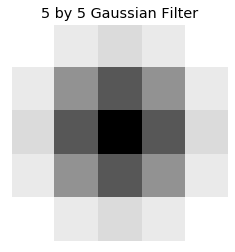

In [38]:
plt.imshow(gaussian_filter, cmap=plt.cm.gray_r, interpolation="nearest")
plt.title("5 by 5 Gaussian Filter")
plt.xticks([]); plt.yticks([])
plt.grid(False)

The numbers in a filter are called its **activations**.  So in the Gaussian filter the biggest weight is in the center, and the values of the weights decrease as we move away from the center.

Tensorflow includes a function `nn.conv2d` which **applies** this convolution to an image (or more generally, a tensor).  Let's see what this operation does to a familiar image.

In [39]:
def apply_convolution_to_image(image,
                               convolutional_filter, 
                               image_shape=(28, 28),
                               filter_shape = (5, 5)):
    """Apply a convolutional filter to an image.  The inputs here should be
    numpy arrays, this function will take care of converting them to tensors
    and back.
    """
    # The image and filter tensor must be 4-tensors to use conv2d.  This
    # will eventually make sense, as we build up the complexity of our
    # filters.
    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    filter_tensor = convolutional_filter.reshape(filter_shape[0], filter_shape[1], 1, 1)
    convolved_tensor = tf.nn.conv2d(input=image_tensor, 
                                    filters=filter_tensor, 
                                    strides=[1, 1, 1, 1], 
                                    padding='SAME')
    image_convloved = convolved_tensor[0, :, :, 0]
    return image_convloved

We will eventually explain the meaning of the reshapes in the function, but in short, Tensorflow always expects to be working on a 4-tensor.  A single image can be represented as a 4-tensor with shape:

```python
(batch_size =1, image_height, image_width, num_of_channel=1)
```

In [40]:
first_digit_blurred = apply_convolution_to_image(first_digit_image, gaussian_filter)

In [41]:
def plot_convolution(before, convolutional_filter, after, axs):
    """Plot a 1 by 3 grid of images:
        - A before image.
        - A filter to apply.
        - The result of convolving the filter with the image.
    """
    axs[0].imshow(before, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Before Convolution")
    axs[1].imshow(convolutional_filter, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Filter")
    axs[2].imshow(after, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[2].set_title("After Convolution")

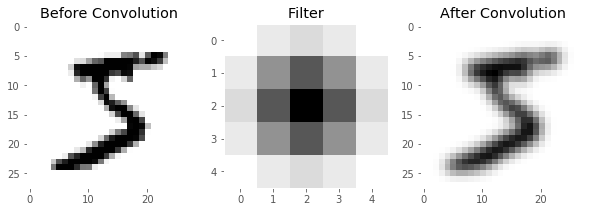

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

plot_convolution(first_digit_image, gaussian_filter, first_digit_blurred, axs)
remove_grid_lines(axs)

**Discussion:** Given the before and after image, and the shape of the filter we applied, what does the operation of **convolution** do?

### Applying a Convolution to an Image

Remember, a convolution is an operation that *combines an image and a filter to create a new image*.

Lets say we have a *28 by 28* image, and a *3 by 3* filter.  The result of the convolution operation is *a 26 by 26* image.

![A Schematic Of A Convolutional Filter](./img/convolution.png)

As hinted at by the picture, the first step is to *overlay the filter on each 3 by 3 patch of the image*.  By sliding the filter around, we eventually cover each 3 by 3 patch of the image. Often time you will see, before convolution we **zero-pad** the original image, that is, adding zeros around the boundary where the filter will spill out over the image; thus we can control the size of the output, specifically, to perserve the size of the image.

![Example of Filter as a Dot Product](./img/convolution-example.png)

The final pixel value in the output image is a **dot product of the pixel intensities** underneath the patch, with the weights in the filter directly above the pixel. 

The name of this operation is a **convolution**, so we can say we **convolve the filter with the image to create our output image**, and it is called **feature map**.

**Discussion:** Given this understanding, why does convolution with a Gaussian filter result in a *fuzzed out* version of the image?

### Edge Detectors

Another type of interesting filter, which will be most important in understanding how ConvNets work, is an **edge detector**.

In [43]:
horizontal_edge_filter = np.array([
    [1,   1,   1,   1,   1],
    [1,   1,   1,   1,   1],
    [0,   0,   0,   0,   0],
    [-1, -1,  -1,  -1,  -1],
    [-1, -1,  -1,  -1,  -1]
]).astype(np.float32)

vertical_edge_filter = np.array([
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1],
    [-1, -1, 0, 1, 1]
]).astype(np.float32)

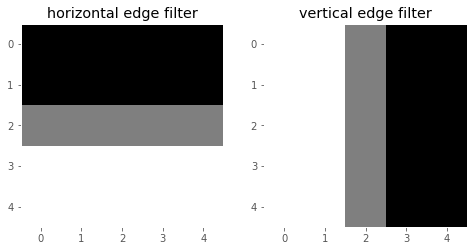

In [44]:
## visualize horizontal / vertical edge filters
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].imshow(horizontal_edge_filter, 
              cmap=plt.cm.gray_r, 
              interpolation="nearest")
axs[0].set_title('horizontal edge filter')

axs[1].imshow(vertical_edge_filter, 
              cmap=plt.cm.gray_r,
              interpolation="nearest")
axs[1].set_title('vertical edge filter')

remove_grid_lines(axs)

Edge detectors show a linear pattern in their weights, they tend to be constant in a fixed direction, and vary from positive to negative along an orthogonal direction.

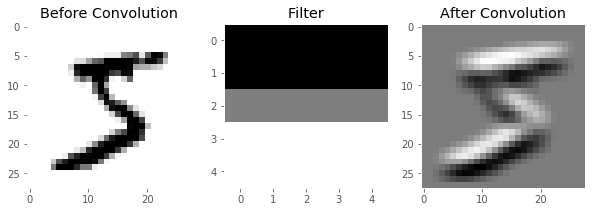

In [45]:
## visualize horizontal edge filter being applied to the raw image
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_h_edges = apply_convolution_to_image(first_digit_image, 
                                                 horizontal_edge_filter)
plot_convolution(first_digit_image, 
                 horizontal_edge_filter,
                 first_digit_h_edges, axs)

remove_grid_lines(axs)

**Discussion:** What did the edge detector do, what feature of the image did it highlight?  (Remember, black pixels are the **activations**, you should think about what the back pixels in the convolved image are detecting).

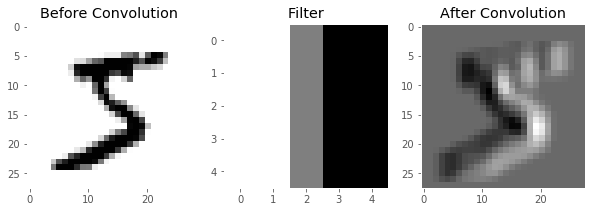

In [46]:
## visualize vertical edge filter being applied to the raw image
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_v_edges = apply_convolution_to_image(first_digit_image, 
                                                 vertical_edge_filter)
plot_convolution(first_digit_image, 
                 vertical_edge_filter, 
                 first_digit_v_edges, 
                 axs)

remove_grid_lines(axs)

**Exercise:** Design an edge detector to highlight the *diagonal* edges in the image.  Apply it to the image to see it in action!

In [ ]:
## You Do!!!
diagonal_edge_filter = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]).astype(np.float32)

In [ ]:
## visualize a diagonal edge filter being applied to the raw image
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

first_digit_d_edges = apply_convolution_to_image(first_digit_image,
                                                   diagonal_edge_filter,
                                                   filter_shape = (5,5))
plot_convolution(first_digit_image, 
                 diagonal_edge_filter, 
                 first_digit_d_edges, 
                 axs)

remove_grid_lines(axs)

### Rectified Linear Unit

Notice that when we convolve an edge detector with an image, the non-edge parts of the image devolve into a grey sludge:

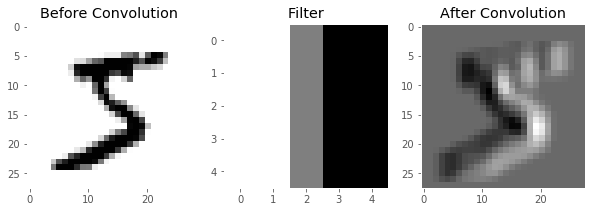

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

plot_convolution(first_digit_image, 
                 vertical_edge_filter, 
                 first_digit_v_edges, axs)
remove_grid_lines(axs)

If we are mostly concerned with where there are and are not edges, we are only really concerned with parts of the transformed image where the activations are large and positive, i.e., the white parts of the convolved image.

A **Rectified Linear Unit** serves to highlight these parts of the image.  It simply implements the following *fixed* transformation:

$$ f(x) = \max(x, 0) $$

In [48]:
def apply_relu(image):
    """Apply a rectified linear unit to an image."""
    return (np.maximum(image, 0))

In [49]:
def plot_relu(image, rectified_image, axs):
    axs[0].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Initial Image")
    axs[1].imshow(rectified_image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Rectified Image")

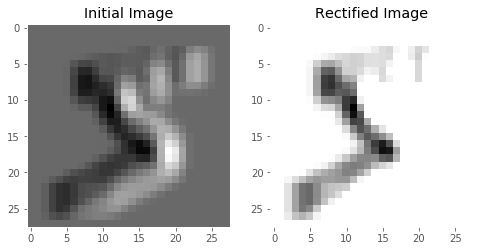

In [50]:
## effect of application of relu
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

first_digit_v_edges_relu = apply_relu(first_digit_v_edges)

plot_relu(first_digit_v_edges, first_digit_v_edges_relu, axs)
remove_grid_lines(axs)

Now the image only highlights the regions in the original image where an edge was detected.

### Max Pooling

A more simple transformation of an image into another is **max pooling**.

In max pooling we again overlay smaller squares onto our image, but this time we tile the squares with no overlap.

The final pixel value in the output image is simply the maximum pixel value over all pixels contained in a region defined by one of the small squares.

![Schematic of Max Pooling](./img/pool.png)

In [51]:
def apply_max_pool_to_image(image, 
                            image_shape=(28, 28), 
                            filter_shape = (2, 2)):
    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    image_pooled_tensor = tf.nn.max_pool(
        image_tensor, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], padding='SAME')
    image_pooled = image_pooled_tensor[0, :, :, 0]
    return image_pooled

In [52]:
def plot_max_pool(image, pooled_image, axs):
    axs[0].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Raw Image")
    axs[1].imshow(pooled_image, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("Pooled Image")

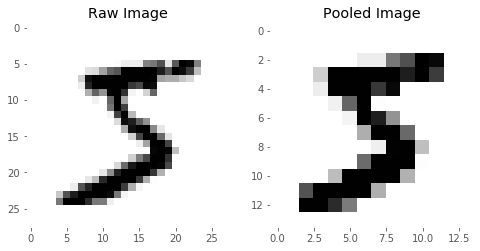

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

first_digit_pooled = apply_max_pool_to_image(first_digit_image)
plot_max_pool(first_digit_image, 
              first_digit_pooled, 
              axs)

remove_grid_lines(axs)

In [96]:
first_digit_image.shape

(28, 28)

You can see that max pooling has **downsampled** features of the image.  We have a smaller image, but displaying the same content at a lower resolution.

Convolutions and max pooling have fundamentally different uses and intent:
  - Convolutions can be used to highlight or manipulate some structure in an image.
  - Max pooling simply downsamples an image to another of smaller size.

#### Chaining Transformations

In ConvNets, these three types of transformations are commonly chained together in the sequence:

```
Convolution -> Rectified Linear Unit -> Max Pool
```

Which we can think of as follows:
  - The convolution **identifies** which regions of an image have a feature.
  - The rectified linear unit **highlights** only the region where the feature exists.
  - The max pooling **downsamples** their resulting information to save space and computation.

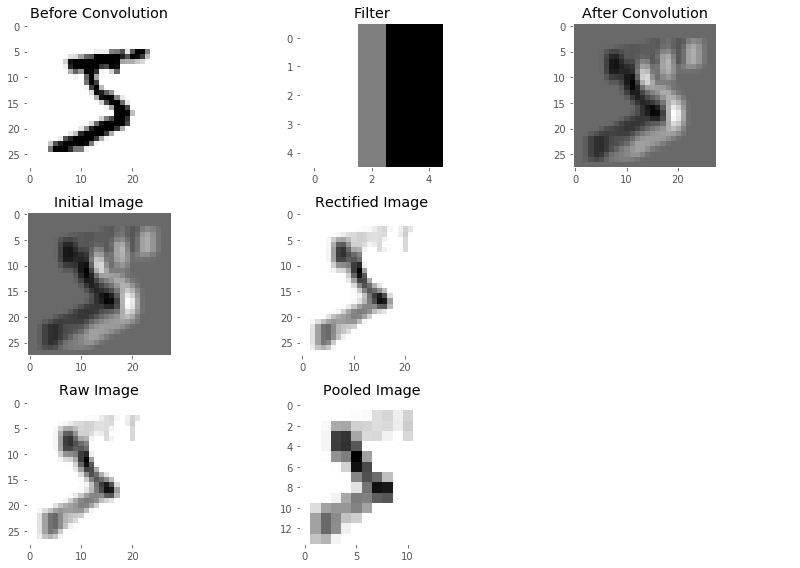

In [54]:
## chaining transformation in action
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

plot_convolution(first_digit_image,
                 vertical_edge_filter,
                 first_digit_v_edges,
                 axs[0, :])
plot_relu(first_digit_v_edges,
          first_digit_v_edges_relu, axs[1, :])
plot_max_pool(first_digit_v_edges_relu,
              apply_max_pool_to_image(first_digit_v_edges_relu),
              axs[2, :])

axs[1, 2].axis('off')
axs[2, 2].axis('off')
remove_grid_lines(axs)
plt.tight_layout()

**Discussion:** How would you detect a *dot* in an image, for example, the dot on the top of a lower case `i`?

**Discussion:** Why use the maximum operation to down sample the features of an image, instead of an average or other operation.

## Convolutional Neural Network Architecture

A convolutional neural network works, as the name hints, by dissecting an image through applying various convolutions.

During training, the job of the network is to discover, from the data, appropriate convolutions that highlight features of the images which help to distinguish between the various classes we are attempting to learn.

The architecture is *layered*, as in the image below (note implicitly the convolution steps shown below include zero-padding)
![scheme](./img/deep-network-begin.png) 
![scheme](./img/deep-network-end.png) 

[visualization on 3d conv](https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610)

There are two layers in the ConvNet above (though what exactly constitutes a layer seems to vary across sources). Each layer implements the chained transformation we discussed above:
```
Convolution -> Rectified Linear Unit -> Max Pool
```

In our network, we've chained together two layers, followed by a fully connected layer, which connects to an output layer, in the same way as in fully connected networks:

```
INPUT -> (CONV -> RELU -> POOL) -> (CONV -> RELU -> POOL) -> FC -> FC -> OUTPUT
```

Below, we will discuss the details of these two layers.  We will assume that our network is **already trained**, so we will be describing a **forward pass**, i.e., what happens to an image that is fed into the network.

### The First Layer

The first layer of our ConvNet acts on the initial image:
    
```
INPUT -> (CONV -> RELU -> POOL) -> ...
```

We already understand what this does when `CONV` is a *single* convolutional filter, this is what we discussed extensively in the previous session.

In a ConvNet though, the `CONV` unit applies **multiple** convolutional filters/channels to the image.

![First Layer Convolutional Filter](./img/convolution-first-layer.png)

Suppose our input image is 28 by 28.  Since there is one image, and we have one color channel (greyscale) we can consider this a 4-tensor of dimensions `(1, 28, 28, 1)`, where:

  - The first `1` is the *one image*.
  - The last `1` is the *one channel*.
  
Suppose that we have sixteen convolutional filters in our first layer.  Each filter is applied to the image independently, so the result is **sixteen 28 by 28 images**.

Here we re-use some terminology, the sixteen output images are again called **channels**, so the output of the first convolutional layer is a tensor with sixteen channels.

So, in all, our dimensions transform as:

```
(1, 28, 28, 1) --SIXTEEN CONVOLUTIONS--> (1, 28, 28, 16)
```

**Convention:** Whenever we have a tensor holding *data*, i.e., an image, multiple images, or transformed images, we will use the following convention for our dimensions:

```
(n_input_images, image_height, image_width, n_channels)
```

After the convolutions, the `RELU` and `POOL` simply act over each channel independently.  So the dimensions work out as:

```
(1, 28, 28, 1) --CONV--> (1, 28, 28, 16)
               --RELU--> (1, 28, 28, 16)
               --POOL--> (1, 14, 14, 16)
```

#### Tensorflow Code

Lets set up the Tensorflow code for our first layer.

In [55]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(28, 28, 1), padding = "same"),
    keras.layers.MaxPooling2D((2, 2))
])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________


The code above reflects the architecture, except for possibly the dimension of the weights for the current convolutional filter:

```
Each filter is 5x5x1 (1 because only grayscale) or 25 values per filter --- plus a single bias term -- 26 total params
So, 26 params per filter x 16 filters = 416 total parameters
```

In our case, there is only one input channel, as our input images are greyscale.  In the subsequent layer, we will have multiple input channels, one for each output channel of the convolutions in this layer.

#### Structure of the First Layer Convolutional Filters

The first layer of convolutions in a well constructed ConvNet frequently show the same type of structures.  They tend to be **edge and point detectors**. Note, it is all after the model is fit. 

Here is a picture of the fit convolutional filters (48 out of 96) from a well trained ConvNet (AlexNet) with many layers (5 conv + 3 fc).

![Edge and Blob Detectors](img/mnist-deep-net-first-layer.jpeg)

Source: http://cs231n.github.io/convolutional-networks

[paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

[more on alexnet (2012)](https://www.learnopencv.com/understanding-alexnet/)

These filters have very clearly converged to edge and color blob detectors.  This is pretty cool.

### The Second Layer

The second layer of our ConvNet acts on (takes as input) the output of our previous layer:
    
```
LAYER_1_OUTPUT -> (CONV -> RELU -> POOL) -> ...
```

This means that the *input* data tensor is a 4-tensor with shape `(1, 14, 14, 16)`.  Recall from above, this tensor represents a *stack of 16 images/channels*.

**Question:** How should we generalize our concept of **convolution** to process a *stack* of images?

**Our prior concept** of a convolution processed a single image (2-tensor) using a filter, which was also a 2-tensor.  Each of our filters in our convolutional unit had a shape:

```
(filter_height, filter_width)
```

and was combined with an image of shape:

```
(image_height, image_width)
```

![A Schematic Of A Convolutional Filter](./img/convolution.png)

**Now** we need to process a 3-tensor (stack of images), so our filter will *also* need to be a 3-tensor.  We will generalize the above to have filters of shape:

```
(filter_height, filter_width, filter_depth)
```

Which we will combine with an image of shape:

```
(image_height, image_width, n_channels)
```

This combination is a direct generalization of the previous case, we only overlay **volumes** instead of **areas**.

![Three Dimensional Filter](img/three-dim-filter.png)

We always make one simplifying restriction in the context of ConvNets:

> We will always use filters whose depth is **equal** to the numbers of channels in the image.

#### Example: Identifying a Higher Level Feature

To see what a later convolutional layer is trying to do, let's consider a simple example.

In [57]:
# Load a image of a zero.  Necessary because we always get the mnist
# dataset in a random order.
clean_zero = np.load("data/zero.npy")

In [58]:
def plot_greyscale_image(ax, image, label):
    """Plot a greyscale image and label its class."""
    first_digit = image.reshape(28, -1)
    ax.imshow(first_digit, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Class: {}".format(label))

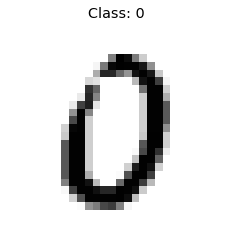

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_greyscale_image(ax, clean_zero, "0")
ax.grid(False)
_ = plt.axis('off')

Let's see how we can combine *two* convolutional layers to detect the upper right hand arc of the zero in this picture.

It's not possible to detect this feature with the simple linear edge detectors we have discussed up until now, but we *can* combine them to get the job done.

Let's start by applying our three edge detectors to this image.

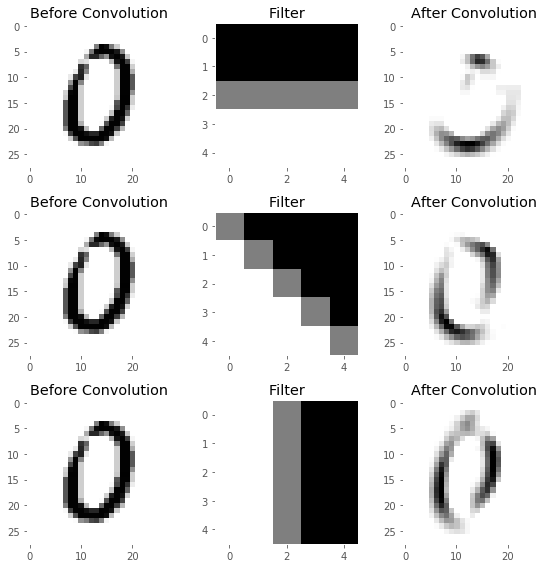

In [60]:
# 3 edge detectors
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

clean_zero_h_edges = apply_relu(apply_convolution_to_image(clean_zero, 
                                                           horizontal_edge_filter))
plot_convolution(clean_zero, 
                 horizontal_edge_filter,
                 clean_zero_h_edges,
                 axs[0, :])

diagonal_edge_filter = np.array([
    [ 0,   1,    1,  1,   1],
    [-1,   0,    1,  1,   1],
    [-1,  -1,    0,  1,   1],
    [-1,  -1,   -1,  0,   1],
    [-1,  -1,   -1, -1,   0]
]).astype(np.float32)

clean_zero_d_edges = apply_relu(apply_convolution_to_image(clean_zero,
                                                           diagonal_edge_filter))
plot_convolution(clean_zero, 
                 diagonal_edge_filter, 
                 clean_zero_d_edges, 
                 axs[1, :])

clean_zero_v_edges = apply_relu(apply_convolution_to_image(clean_zero, vertical_edge_filter))
plot_convolution(clean_zero, vertical_edge_filter, clean_zero_v_edges, axs[2, :])

remove_grid_lines(axs)
plt.tight_layout()

If we imagine that these edge detectors are the first convolutional layer of our ConvNet, then the output of this layer is a 3-tensor with the max-pooled outputs of the edge detectors stacked together.

--> Image of 3 convolution layers applied to zero.

In [61]:
stacked_filtered_zeros = np.stack([
    apply_max_pool_to_image(clean_zero_h_edges),
    apply_max_pool_to_image(clean_zero_d_edges),
    apply_max_pool_to_image(clean_zero_v_edges) 
], axis=-1)

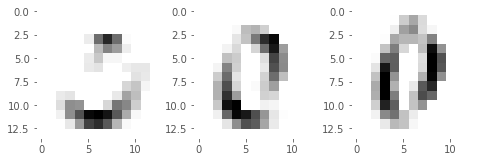

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
axs[0].imshow(stacked_filtered_zeros[:, :, 0], cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(stacked_filtered_zeros[:, :, 1], cmap=plt.cm.gray_r, interpolation="nearest")
axs[2].imshow(stacked_filtered_zeros[:, :, 2], cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

To detect the curve of the upper right hand side of the zero, we will construct a convolution in our second layer that "glues together" the edge detectors.

More precisely, we will attempt to detect the *pattern of activations* from the convolutions in the first layer:
  - The activation from the horizontal edge detector at the top.
  - The activation from the diagonal detector slightly below and to the right of that.
  - The activation from the vertical detector slightly below and to the right of that.

In [63]:
# This is a simple template for a blob detector.
template = np.array([
    [0.25, 0.5, 0.25],
    [0.50, 1.0, 0.50],
    [0.25, 0.5, 0.25],
])

# Put together three blob detectors in the correct pattern.
three_filter = np.zeros((5, 5, 3), dtype=np.float32)

three_filter[:3,  :3,  0] = template
three_filter[1:4, 1:4, 1] = template
three_filter[2:,  2:,  2] = template

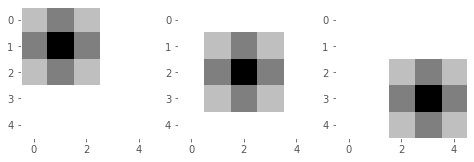

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
axs[0].imshow(three_filter[:, :, 0], cmap=plt.cm.gray_r, interpolation="nearest")
axs[1].imshow(three_filter[:, :, 1], cmap=plt.cm.gray_r, interpolation="nearest")
axs[2].imshow(three_filter[:, :, 2], cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

You can think of these filters as identifying where to "glue" the detectors from the first layer to create a pattern that will detect the curve we are after.

In [65]:
def apply_three_convolution_to_image_stack(images, filters):
    images_shape = images.shape
    image_tensor = images.reshape(1, images_shape[0], images_shape[1], images_shape[2])
    filters_shape = filters.shape
    filter_tensor = filters.reshape(filters_shape[0], filters_shape[1], filters_shape[2], 1)
    convolved_tensor = tf.nn.conv2d(
        image_tensor, filter_tensor, 
        strides=[1, 1, 1, 1], padding='SAME')
    image_convloved = convolved_tensor[0, :, :, 0]
    return image_convloved

In [66]:
stacked_filtered_zeros.shape

(14, 14, 3)

In [67]:
three_filter.shape

(5, 5, 3)

In [68]:
double_filtered_image = apply_three_convolution_to_image_stack(
    stacked_filtered_zeros, three_filter)

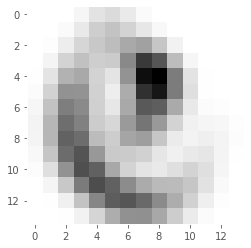

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(double_filtered_image, cmap=plt.cm.gray_r, interpolation="nearest")
ax.grid(False)

The strong activation in this picture (the mass of dense black pixels) serves to detect the feature we are after.

Essentially, if we lay down our three edge detectors from the first layer in the pattern defined by the second layer, centered on the point of strongest activation in the image above, we will detect the curve of the upper right hand side of the zero.

#### Tensorflow Code

Our network will contain 32 convolutional filters in the second layer.

This means we are creating 32 "patterns" for gluing the 16 convolutions from the **first** layer together so as to detect more complex features.

This means that overall, the second layer transforms the dimensions of the input tensor as:

```
(1, 14, 14, 16) -CONV-> (1, 14, 14, 32)
                -RELU-> (1, 14, 14, 32)
                -POOL-> (1, 7, 7, 32)
```

In [70]:
model.add(keras.layers.Conv2D(32, (5, 5), activation = 'relu', padding = 'same'))
model.add(keras.layers.MaxPool2D(2,2))

In [71]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
Total params: 13,248
Trainable params: 13,248
Non-trainable params: 0
_________________________________________________________________


```
There are 32 filters for the second layer
Each filter is 5x5x16 (16 because that is the output of the 1st conv layer) --- plus add a bias per filter
So, (((5x5x16) + 1) * 32 filters) == 12832 parameters to train
```

### The Fully Connected Layer

To finish off the network, we add a fully connected layer, and then an output layer.

![Schematic of a Complete CNN End](./img/deep-network-end.png) 

The final fully connected layer will contain 128 final numeric features which are linear combinations of the higher level features from the second convolutional layer.

In [72]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation = "relu"))

These 128 features are then connected to the output layer, which will give us our predictions for each fashion article.

In [73]:
model.add(keras.layers.Dense(10,  activation = "softmax"))

In [74]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

### Training the Network

#### Loss Function and Regularization

To train our network, we will use a more sophisticated method than vanilla stochastic gradient descent.  

And we need to set up a loss function. As usual, we train our network by minimizing a cross entropy loss function.

In [75]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
train_images.shape

(60000, 28, 28, 1)

#### Training The Network

The Tensorflow code to train the network is straightforward.

In [76]:
train_images = train_images.reshape((60000, 28, 28, 1))

# ADAM is a sophisticated version of gradient descent that adapts the
# learning rate over time.
model.fit(train_images, train_labels, epochs=10, verbose=2)

Train on 60000 samples
Epoch 1/10
60000/60000 - 26s - loss: 0.1339 - accuracy: 0.9582
Epoch 2/10
60000/60000 - 27s - loss: 0.0431 - accuracy: 0.9869
Epoch 3/10
60000/60000 - 27s - loss: 0.0304 - accuracy: 0.9905
Epoch 4/10
60000/60000 - 32s - loss: 0.0212 - accuracy: 0.9934
Epoch 5/10
60000/60000 - 27s - loss: 0.0173 - accuracy: 0.9945
Epoch 6/10
60000/60000 - 26s - loss: 0.0136 - accuracy: 0.9955
Epoch 7/10
60000/60000 - 26s - loss: 0.0106 - accuracy: 0.9966
Epoch 8/10
60000/60000 - 26s - loss: 0.0096 - accuracy: 0.9970
Epoch 9/10
60000/60000 - 26s - loss: 0.0085 - accuracy: 0.9972
Epoch 10/10
60000/60000 - 26s - loss: 0.0066 - accuracy: 0.9976


I'm not running more epochs as this takes a **long time**... Even after only 10 epochs, our convolutional network has given us a nice increase in our ability to detect digits.

In [77]:
test_images = test_images.reshape((10000, 28, 28, 1))
start_time = timeit.default_timer()
test_loss, test_acc = model.evaluate(test_images, test_labels)
elapsed = timeit.default_timer() - start_time
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))
print('\nTook {:.2f}s to finish'.format(elapsed))

10000/10000 [==============================] - 2s 162us/sample - loss: 0.0559 - accuracy: 0.9882

Test data, accuracy: 98.82%

Took 1.68s to finish


[optional] How to speed it up? [Read on](https://www.tensorflow.org/alpha/tutorials/distribute/training_loops)

### Save your model

It can take a long time to fit a good model (in reality, it could mean multiple GPUs, hours or days to achieve acceptable accuracy. What cause the long run-time? Well, the size of training dataset, number of parameters to be trained, etc.), it makes sense if we could re-use our fit model after all that effort and spent resources. We want to save the fit model.

In [78]:
## make the name distinguiable (at least to you)
from datetime import datetime
saved_model_path = "./saved_models/mnist_10epochs_{}.h5".format(datetime.now().strftime("%Y%m%d")) # _%H%M%S
# Save entire model to a HDF5 file
model.save(saved_model_path)

To re-use, or further training, we just load the fit model. Let's do that and do a sanity check.

In [79]:
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model(saved_model_path)

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

In [80]:
test_loss, test_acc = new_model.evaluate(test_images, test_labels)
print("\nTest data, accuracy: {:5.2f}%".format(100*test_acc))

10000/10000 [==============================] - 2s 154us/sample - loss: 0.0559 - accuracy: 0.9882

Test data, accuracy: 98.82%


### Regularization

You probably noticed that the accuracy from the model was pretty high. One is that the dataset is quite simple, ConvNet was built for it. The other thing is overfitting. 

Deep NNs are prone to overfitting, and there's a way to deal with it by simply adding a layer `tf.keras.layers.Dropout(rate)` when you build the model. The rate is the proportion of the nuerons you would like to drop. 

Or add L2 regularization on all the weights in the network to prevent overfitting.  This is always a good idea, and much effort in training production ConvNets is spent validating the choice of this (regularization strength) and other hyperparameters.

### Visualizing the First Layer

Now we can visualize the fit convolutions in the first layer of our network.

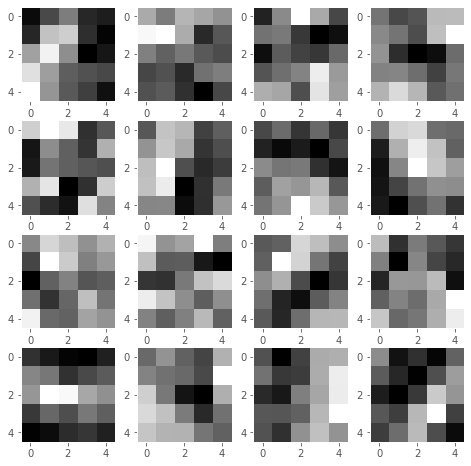

In [81]:
weights1_np = model.get_weights()[0] # 5 5 1 16

fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    filter = weights1_np[:, :, 0, i]
    ax.imshow(filter, cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

As stated earlier, the first layer convolutions show characteristic signs of being edge detectors.

Let's apply these filters to our digit from earlier:

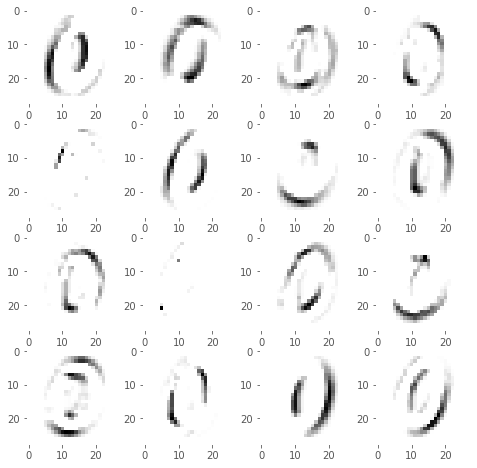

In [82]:
zero_tensor = tf.constant(clean_zero.reshape(1, 28, 28, 1))
zero_activations = tf.nn.conv2d(
    zero_tensor, weights1_np, strides=[1, 1, 1, 1], padding='SAME'
)
# or keras.activations.relu(zero_activations)
zero_activations_relu = np.maximum(zero_activations,0) 
# plot
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(zero_activations_relu[0, :, :, i],
              cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

# End of Notebook

---

In [83]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

ModuleNotFoundError: No module named 'keras'

In [84]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

ModuleNotFoundError: No module named 'keras'